In [19]:
import numpy as np
from sklearn.metrics import roc_curve
from scipy.optimize import brentq
from scipy.interpolate import interp1d
import pandas as pd
import matplotlib.pyplot as plt
import cPickle

# Score combination

In [20]:
base_dir = "/Users/lmatayoshi/Documents/Projects/tesis_notebooks/final_experiments/heldout/"
features_combination_dir = base_dir + "features_combination/single/"
score_combination_dir = base_dir + "score_combination/"
supervectors_single_phonemes_dir = score_combination_dir + "supervectors_single_phonemes/"
dct_single_phonemes_dir = score_combination_dir + "dct_single_phonemes/"
plots_dir = base_dir + "plots/"
score_combination_plots_dir = plots_dir + "score_combination/"
features_combination_plots_dir = plots_dir + "features_combination/"
barplots_dir = plots_dir + "barplots/"

In [44]:
phonemes = ["c", "x", "G", "d", "b", "g", "z", "w", "N", "B", "rr", "u", "p", "D", "y", "k", "m", "t", "l", "i", "r", "n", "s", "o", "a", "e"]
phonemes_by_kappa = ["b", "m", "B", "s", "D", "G", "w", "i", "y", "p", "r", "z", "t", "k", "rr", "a", "o", "l", "e", "n", "u", "c", "x", "d", "g", "N"]
mcnemar_phonemes = ['m', 's', 'i', 'y', 'z', 'k', 'rr', 'a', 'o', 'l', 'e', 'n']

In [22]:
supervectors_original_values = dict(zip(phonemes_by_kappa, [0.133, 0.186, 0.179, 0.252, 0.185, 0.152, 0.141, 0.252, 0.371, 0.315, 0.331, 0.242, 0.323, 0.304, 0.341, 0.371, 0.387, 0.289, 0.392, 0.382, 0.355, 0.308, 0.135, 0.304, 0.236, 0.203]))
features_combination_original_values = dict(zip(phonemes_by_kappa, [0.133, 0.175, 0.183, 0.258, 0.185, 0.152, 0.133, 0.258, 0.346, 0.311, 0.307, 0.245, 0.308, 0.302, 0.336, 0.358, 0.396, 0.267, 0.384, 0.379, 0.355, 0.375, 0.135, 0.314, 0.236, 0.192]))
score_combination_original_values = dict(zip(phonemes_by_kappa, [0.135, 0.176, 0.185, 0.224, 0.183, 0.159, 0.141, 0.243, 0.355, 0.315, 0.324, 0.245, 0.312, 0.289, 0.336, 0.36, 0.383, 0.272, 0.383, 0.364, 0.329, 0.333, 0.135, 0.309, 0.228, 0.216]))

In [23]:
def load_heldout_speakers():
	speakers_filename = base_dir + "heldout_speakers"
	with open(speakers_filename, "r") as f:
		speakers = [line.rstrip() for line in f.readlines()]
	return speakers

In [5]:
def all_phonemes_empty_dict(phonemes):
    return dict(zip(phonemes, [[] for p in phonemes]))

In [6]:
def load_positives_negatives_dict():
    phonemes = ["b", "m", "B", "s", "D", "G", "w", "i", "y", "p", "r", "z", "t", "k", "rr", "a", "o", "l", "e", "n", "u", "c", "x", "d", "g", "N"]
    positive_values = [140, 801, 126, 1963, 268, 61, 179, 1224, 596, 441, 910, 49, 733, 434, 122, 2509, 2030, 851, 2658, 1792, 471, 104, 161, 191, 237, 246]
    positive_values = [str(p) for p in positive_values]
    negative_values = [95, 188, 302, 107, 486, 145, 128, 301, 156, 254, 641, 247, 360, 388, 453, 548, 548, 356, 899, 125, 110, 24, 37, 18, 29, 116]
    negative_values = [str(n) for n in negative_values]
    positives_dict = dict(zip(phonemes, positive_values))
    negatives_dict = dict(zip(phonemes, negative_values))
    return (positives_dict, negatives_dict)

In [7]:
def check_logids(lines_supervectors, lines_second_source):
    logids_supervectors = [l[0] for l in lines_supervectors]
    logids_second_source = [l[0] for l in lines_second_source]
    if not logids_supervectors == logids_second_source:
        raise Exception(phoneme + " logids doesn't match in supervectors vs second source")
    

In [8]:
def label_for(label):
    if label == "True":
        return 1
    elif label == "False":
        return -1

In [9]:
def compute_EER(tuples):
    labels = [t[1] for t in tuples]
    hyperplane_distances = [t[0] for t in tuples]
    fpr, tpr, _ = roc_curve(labels, hyperplane_distances)
    # eer is where fpr is equal to fnr
    eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
    return eer

In [10]:
def lines_for_speaker(lines, speaker):
    return [line for line in lines if speaker in line[0]]

In [11]:
def generate_shuffled_speakers_list(speakers, n):
    res = []
    for i in range(n):
        res.append(shuffled_with_replacement(speakers))
    return res

In [12]:
def shuffled_with_replacement(speakers):
	n_speakers = len(speakers)
	shuffled_indexes_with_replacement = np.random.randint(n_speakers, size=n_speakers)
	return [speakers[j] for j in shuffled_indexes_with_replacement]

Para cada fonema, combino scores utilizando como factor el diccionario pasado por parámetro. Hago una primera iteración utilizando todos los speakers sin repetición

In [13]:
def main(proportion_dict):
    ### Dictionary generation 
    heldout_speakers = load_heldout_speakers()
    shuffled_speakers_list = generate_shuffled_speakers_list(heldout_speakers, 1000)
    res = all_phonemes_empty_dict(phonemes)
    supervectors_dir = supervectors_single_phonemes_dir
    second_source_dir = dct_single_phonemes_dir
    for phoneme in phonemes:
        original_phoneme = phoneme
        if phoneme in ['g', 'y', 'd', 'b', 'n']:
            phoneme = phoneme + "_lowercase"
        supervectors_filename = supervectors_dir + phoneme
        second_source_filename = second_source_dir + phoneme
        with open(supervectors_filename, "r") as f_supervectors:
            lines_supervectors = f_supervectors.readlines()
            lines_supervectors = [l.split(" ") for l in lines_supervectors]
        with open(second_source_filename, "r") as f_second_source:
            lines_second_source = f_second_source.readlines()
            lines_second_source = [l.split(" ") for l in lines_second_source]
        check_logids(lines_supervectors, lines_second_source)
        
        for speakers in shuffled_speakers_list:
            new_lines_supervectors = []
            new_lines_second_source = []
            for speaker in speakers:
                new_lines_supervectors = new_lines_supervectors + lines_for_speaker(lines_supervectors, speaker)
                new_lines_second_source = new_lines_second_source + lines_for_speaker(lines_second_source, speaker)
            check_logids(new_lines_supervectors, new_lines_second_source)
            
            phoneme_values = []
            for i in range(len(new_lines_supervectors)):
                new_value = float(new_lines_supervectors[i][4]) + proportion_dict[original_phoneme]*float(new_lines_second_source[i][4])
                new_line = new_lines_supervectors[i]
                label = label_for(new_line[3])
                new_tuple = (new_value, label)
                #new_line[4] = str(new_value)
                #new_line = " ".join(new_line) + "\n"
                phoneme_values.append(new_tuple)
            res[original_phoneme].append(compute_EER(phoneme_values))
    
    return res

In [14]:
def main_single_source(type):
    ### Dictionary generation 
    heldout_speakers = load_heldout_speakers()
    shuffled_speakers_list = generate_shuffled_speakers_list(heldout_speakers, 1000)
    res = all_phonemes_empty_dict(phonemes)
    if type == "supervectors":
        supervectors_dir = supervectors_single_phonemes_dir
    else:
        supervectors_dir = features_combination_dir
    for phoneme in phonemes:
        original_phoneme = phoneme
        if phoneme in ['g', 'y', 'd', 'b', 'n']:
            phoneme = phoneme + "_lowercase"
        supervectors_filename = supervectors_dir + phoneme
        with open(supervectors_filename, "r") as f_supervectors:
            lines_supervectors = f_supervectors.readlines()
            lines_supervectors = [l.split(" ") for l in lines_supervectors]
        
        for speakers in shuffled_speakers_list:
            new_lines_supervectors = []
            for speaker in speakers:
                new_lines_supervectors = new_lines_supervectors + lines_for_speaker(lines_supervectors, speaker)
            
            phoneme_values = []
            for i in range(len(new_lines_supervectors)):
                new_value = float(new_lines_supervectors[i][4]) 
                new_line = new_lines_supervectors[i]
                label = label_for(new_line[3])
                new_tuple = (new_value, label)
                #new_line[4] = str(new_value)
                #new_line = " ".join(new_line) + "\n"
                phoneme_values.append(new_tuple)
            res[original_phoneme].append(compute_EER(phoneme_values))
    
    return res

In [15]:
score_combination_factor_dict = {
    'Y': 0.8,
    'c': 0.9,
    'f': 0.4,
    'x': 0.6,
    'd': 0.2,
    'G': 0.1,
    'b': 0.1,
    'g': 0.1,
    'z': 0.3,
    'w': 0.0,
    'N': 1.0,
    'B': 0.3,
    'rr': 0.9,
    'u': 1.0,
    'p': 0.0,
    'D': 0.1,
    'y': 1.0,
    'k': 0.2,
    'm': 0.6,
    't': 0.6,
    'l': 0.8,
    'i': 0.3,
    'r': 0.6,
    'n': 0.7,
    's': 1.0,
    'o': 0.9,
    'a': 0.7,
    'e': 0.6
}

# Score combination original values

In [24]:
def score_combination_values():
    ### Dictionary generation 
    heldout_speakers = load_heldout_speakers()
    shuffled_speakers_list = generate_shuffled_speakers_list(heldout_speakers, 1000)
    res = all_phonemes_empty_dict(phonemes)
    supervectors_dir = supervectors_single_phonemes_dir
    second_source_dir = dct_single_phonemes_dir
    for phoneme in phonemes:
        original_phoneme = phoneme
        if phoneme in ['g', 'y', 'd', 'b', 'n']:
            phoneme = phoneme + "_lowercase"
        supervectors_filename = supervectors_dir + phoneme
        second_source_filename = second_source_dir + phoneme
        with open(supervectors_filename, "r") as f_supervectors:
            lines_supervectors = f_supervectors.readlines()
            lines_supervectors = [l.split(" ") for l in lines_supervectors]
        with open(second_source_filename, "r") as f_second_source:
            lines_second_source = f_second_source.readlines()
            lines_second_source = [l.split(" ") for l in lines_second_source]
        check_logids(lines_supervectors, lines_second_source)
        
        ### primera iteracion ###
        new_lines_supervectors = []
        new_lines_second_source = []
        for speaker in heldout_speakers:
            new_lines_supervectors = new_lines_supervectors + lines_for_speaker(lines_supervectors, speaker)
            new_lines_second_source = new_lines_second_source + lines_for_speaker(lines_second_source, speaker)
        check_logids(new_lines_supervectors, new_lines_second_source)
        phoneme_values = []
        for i in range(len(new_lines_supervectors)):
            new_value = float(new_lines_supervectors[i][4]) + score_combination_factor_dict[original_phoneme]*float(new_lines_second_source[i][4])
            new_line = new_lines_supervectors[i]
            label = label_for(new_line[3])
            new_tuple = (new_value, label)
            #new_line[4] = str(new_value)
            #new_line = " ".join(new_line) + "\n"
            phoneme_values.append(new_tuple)
        res[original_phoneme].append(compute_EER(phoneme_values))
        
    return res

In [25]:
score_combination_values()

{'B': [0.1849315068492798],
 'D': [0.183127572017706],
 'G': [0.15862068965486847],
 'N': [0.21551724137838293],
 'a': [0.359980736816759],
 'b': [0.13548387096774195],
 'c': [0.3333333333334383],
 'd': [0.30890052356020953],
 'e': [0.3831447522434647],
 'g': [0.22784810126582278],
 'i': [0.24263368497641655],
 'k': [0.28865979381518947],
 'l': [0.2724719101133137],
 'm': [0.17553191489292716],
 'n': [0.363839285714298],
 'o': [0.3832512315270936],
 'p': [0.3149606299202958],
 'r': [0.3241758241758241],
 'rr': [0.3360655737704616],
 's': [0.22429906542129918],
 't': [0.3124147339699169],
 'u': [0.3290870488322718],
 'w': [0.14062499999989342],
 'x': [0.13513513513547643],
 'y': [0.35462555066079904],
 'z': [0.24489795918367355]}

In [186]:
#score_combination = main(score_combination_factor_dict)

In [110]:
#supervectors = main_single_source("supervectors")

In [115]:
#features_combination = main_single_source("feature_combination")

In [26]:
dicts_dir = base_dir + "dicts/"
supervectors_dict_filename = dicts_dir + "supervectors_dict"
score_combination_dict_filename = dicts_dir +"score_combination_dict"
features_combination_dict_filename = dicts_dir +"features_combination_dict"

with open(supervectors_dict_filename, "rb") as f:
    supervectors = cPickle.load(f)
with open(score_combination_dict_filename, "rb") as f:
    score_combination = cPickle.load(f)
with open(features_combination_dict_filename, "rb") as f:
    features_combination = cPickle.load(f)

# Results analysis

In [21]:
score_combination

{'B': [0.16279069767398,
  0.2290076335875048,
  0.19499105545617174,
  0.18032786885245897,
  0.19551282051162414,
  0.22131147540983775,
  0.16417910447754588,
  0.1688741721854477,
  0.18139534883719946,
  0.1699664940603107,
  0.18828451882845187,
  0.15614617940333364,
  0.19658119658114032,
  0.18927444794966466,
  0.15625000000074254,
  0.19580419580418168,
  0.1896551724137931,
  0.18989800874210783,
  0.16246498599526138,
  0.1981132075470848,
  0.17777777777777776,
  0.1781305114638448,
  0.17532467532427262,
  0.19999999999974835,
  0.17346938775521123,
  0.14885496183084282,
  0.20769230769195543,
  0.13793103448275862,
  0.1925675675661195,
  0.20382165605087507,
  0.17880794701899677,
  0.1734693877551023,
  0.21805392731535755,
  0.1875,
  0.1621621621621632,
  0.19242902208154036,
  0.172093023255814,
  0.17523364485981308,
  0.2083086053412463,
  0.17218543046377494,
  0.19444444444444445,
  0.18543046357583956,
  0.18487394957952138,
  0.15424354243542435,
  0.1893687

In [28]:
for phoneme in phonemes_by_kappa:
    print "Phone: " + phoneme
    print "Supervectors: " + str(np.mean(supervectors[phoneme]))
    print "Supervectors original: " + str(supervectors_original_values[phoneme])
    
    print "Score combination: " + str(np.mean(score_combination[phoneme]))
    print "Score combination original: " + str(score_combination_original_values[phoneme])
    
    print "Features combination: " + str(np.mean(features_combination[phoneme]))
    print "Features combination original: " + str(features_combination_original_values[phoneme])
    print "\n"

Phone: b
Supervectors: 0.125085485033
Supervectors original: 0.133
Score combination: 0.126054689893
Score combination original: 0.135
Features combination: 0.124973674666
Features combination original: 0.133


Phone: m
Supervectors: 0.184291578761
Supervectors original: 0.186
Score combination: 0.170032578655
Score combination original: 0.176
Features combination: 0.174897238413
Features combination original: 0.175


Phone: B
Supervectors: 0.176716983702
Supervectors original: 0.179
Score combination: 0.18390142594
Score combination original: 0.185
Features combination: 0.181443352151
Features combination original: 0.183


Phone: s
Supervectors: 0.258663531991
Supervectors original: 0.252
Score combination: 0.228522648484
Score combination original: 0.224
Features combination: 0.245967334243
Features combination original: 0.258


Phone: D
Supervectors: 0.185891880682
Supervectors original: 0.185
Score combination: 0.186411606324
Score combination original: 0.183
Features combination: 

# Barplot

In [37]:
#def calculate_tuple(eers):
#    eers = np.array(eers)
#    trimmed_eers = eers
#    n_instances = eers.shape[0]
#    n_trim_each_tail = int((2.5 * n_instances) / 100)
#    trimmed_eers = np.sort(eers)
#    trimmed_eers = trimmed_eers[n_trim_each_tail: -n_trim_each_tail]
#    mean = np.mean(eers)
#    min_error = np.abs(mean - np.min(trimmed_eers))
#    max_error = np.abs(mean - np.max(trimmed_eers))
#    return {"mean": mean, "min": min_error, "max": max_error}

In [38]:
def calculate_tuple(eers, p, type):
    eers = np.array(eers)
    trimmed_eers = eers
    n_instances = eers.shape[0]
    n_trim_each_tail = int((2.5 * n_instances) / 100)
    trimmed_eers = np.sort(eers)
    trimmed_eers = trimmed_eers[n_trim_each_tail: -n_trim_each_tail]
    #mean = np.mean(eers)
    if type == "supervectors":
        mean = supervectors_original_values[p]
    elif type == "features_combination":
        mean = features_combination_original_values[p]
    elif type == "score_combination":
        mean = score_combination_original_values[p]
    min_error = np.abs(mean - np.min(trimmed_eers))
    max_error = np.abs(mean - np.max(trimmed_eers))
    return {"mean": mean, "min": min_error, "max": max_error}

In [32]:
def empty_model_entry():
    return {"mean": None, "min": None, "max": None}

In [47]:
def plot_barplots(phonemes, title, filename=None, position=""):
    phonemes_by_kappa = ["b", "m", "B", "s", "D", "G", "w", "i", "y", "p", "r", "z", "t", "k", "rr", "a", "o", "l", "e", "n", "u", "c", "x", "d", "g", "N"]
    barplot_values = [{"supervectors": empty_model_entry(), "features_combination": empty_model_entry(), "score_combination": empty_model_entry()} for p in phonemes_by_kappa]
    barplot_dicc = dict(zip(phonemes_by_kappa, barplot_values))
    for p in phonemes:
        barplot_dicc[p]["supervectors"] = calculate_tuple(supervectors[p], p, "supervectors")
        barplot_dicc[p]["features_combination"] = calculate_tuple(features_combination[p], p, "features_combination")
        barplot_dicc[p]["score_combination"] = calculate_tuple(score_combination[p], p, "score_combination")
        
    min_yerr_supervectors = [barplot_dicc[p]["supervectors"]["min"] for p in phonemes]
    max_yerr_supervectors = [barplot_dicc[p]["supervectors"]["max"] for p in phonemes]

    min_yerr_features_combination = [barplot_dicc[p]["features_combination"]["min"] for p in phonemes]
    max_yerr_features_combination = [barplot_dicc[p]["features_combination"]["max"] for p in phonemes]

    min_yerr_score_combination = [barplot_dicc[p]["score_combination"]["min"] for p in phonemes]
    max_yerr_score_combination = [barplot_dicc[p]["score_combination"]["max"] for p in phonemes]
    
    barWidth = 0.4
    xs_1 = np.arange(len(phonemes)) * 1.6
    xs_2 = [x + barWidth for x in xs_1]
    xs_3 = [x + 2*barWidth for x in xs_1]

    ys_1 = [barplot_dicc[p]["supervectors"]["mean"] for p in phonemes]
    ys_2 = [barplot_dicc[p]["features_combination"]["mean"] for p in phonemes]
    ys_3 = [barplot_dicc[p]["score_combination"]["mean"] for p in phonemes]
    plt.bar(xs_1, ys_1, width=barWidth, color="#3C99BF", yerr=[min_yerr_supervectors, max_yerr_supervectors], capsize=2, label="supervectors")
    plt.bar(xs_2, ys_2, width=barWidth, color="#7EED91", yerr=[min_yerr_features_combination, max_yerr_features_combination], capsize=2, label="features combination")
    plt.bar(xs_3, ys_3, width=barWidth, color="red", yerr=[min_yerr_score_combination, max_yerr_score_combination], capsize=2, label="score combination")
    plt.xticks(xs_2, phonemes)
    plt.legend(loc=position)
    plt.xlabel("phones")
    plt.ylabel("EER")
    plt.title(title)
    plt.savefig(filename)
    plt.show()

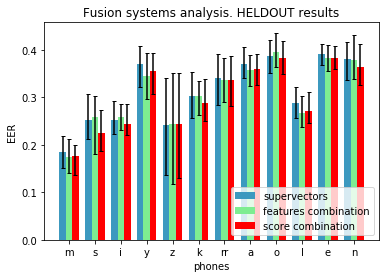

In [48]:
title = "Fusion systems analysis. HELDOUT results"
output_filename = barplots_dir + "heldout_mcnemar_phones"
plot_barplots(mcnemar_phonemes, title, filename=output_filename, position="lower right")

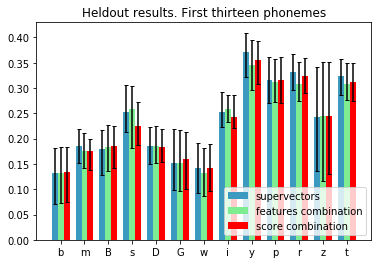

In [42]:
title = "Heldout results. First thirteen phonemes"
output_filename = barplots_dir + "heldout_part_1"
plot_barplots(phonemes_by_kappa[:13], title, filename=output_filename, position="lower right")

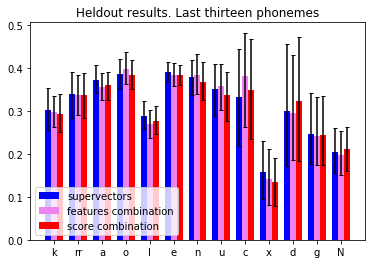

In [75]:
title = "Heldout results. Last thirteen phonemes"
output_filename = barplots_dir + "heldout_part_2"
plot_barplots(phonemes_by_kappa[13:], title, filename=output_filename)

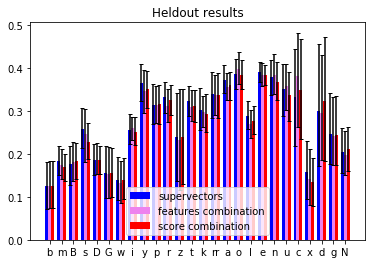

In [80]:
title = "Heldout results"
output_filename = barplots_dir + "heldout_all"
plot_barplots(phonemes_by_kappa, title, filename=output_filename)

# Histograms

In [23]:
def text_for_delta(number):
    if number > 0:
        return "+"
    else:
        return "-"

In [24]:
def plot_and_save_histogram(supervectors, score_combination, phoneme, label, title_info, output_filename=None):
    n_bins = 30
    #counts_positives_negatives, bins_positives_negatives, patches_positives_negatives = plt.hist(positives_negatives_distances, n_bins)
    counts_both, bins_both, _ = plt.hist(supervectors + score_combination, n_bins)

    ################
    # SUPERVECTORS # 
    ################

    n_supervectors, bins_supervectors, _ = plt.hist(supervectors, bins=bins_both)
    plt.clf()
    #normalized_positives = n_positives/total_positives

    #####################
    # SCORE COMBINATION #
    #####################

    n_score_combination, bins_score_combination, _ = plt.hist(score_combination, bins=bins_both)
    #normalized_negatives = n_negatives/total_negatives

    fixed_bins = []
    for i in range(0, len(bins_both) - 1):
        mean = (bins_both[i] + bins_both[i+1]) / 2
        fixed_bins.append(mean)

    plt.clf()
    
    supervectors_mean = np.mean(supervectors)
    combination_mean = np.mean(score_combination)
    delta = (supervectors_mean - combination_mean) / supervectors_mean
    delta_text = text_for_delta(delta) + "%.2f" % np.abs(delta) + "% " 
    p_value_text = "P-value: " + title_info['p-value']
    positive_negatives_text = "Positives: " + title_info['n_positives'] + ", Negatives: " + title_info['n_negatives']
    plt.title("Heldout '" + phoneme + "' " + delta_text + ", " + positive_negatives_text )
    #plt.figure(figsize= (22,7))
    plt.plot(fixed_bins, n_supervectors, color="blue", label="supervectors")   
    plt.plot(fixed_bins, n_score_combination, color="red", label= label)
    plt.axvline(x=supervectors_mean, linestyle="--", linewidth=0.5, color="blue")
    plt.axvline(x=combination_mean, linestyle="--", linewidth=0.5, color="red")
    plt.legend()
    plt.xticks(fixed_bins, rotation='vertical')
    plt.tight_layout()
    plt.xlabel("EER")
    plt.ylabel("count")
    if output_filename:
        plt.savefig(output_filename)
    plt.show()


# Score combination

In [28]:
positives_dict, negatives_dict = load_positives_negatives_dict()

/Users/lmatayoshi/Documents/Projects/tesis_notebooks/final_experiments/heldout/plots/score_combination/c


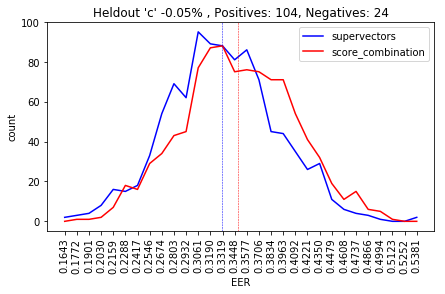

/Users/lmatayoshi/Documents/Projects/tesis_notebooks/final_experiments/heldout/plots/score_combination/x


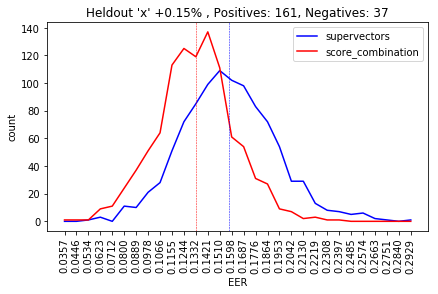

/Users/lmatayoshi/Documents/Projects/tesis_notebooks/final_experiments/heldout/plots/score_combination/G


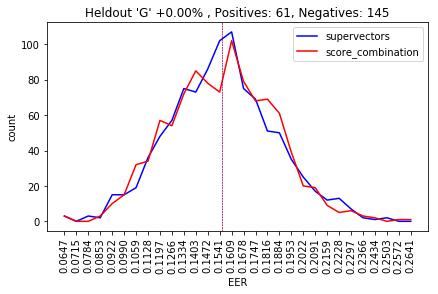

/Users/lmatayoshi/Documents/Projects/tesis_notebooks/final_experiments/heldout/plots/score_combination/d_lowercase


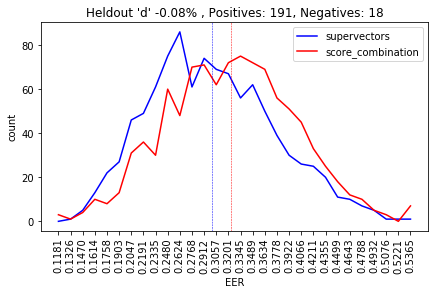

/Users/lmatayoshi/Documents/Projects/tesis_notebooks/final_experiments/heldout/plots/score_combination/b_lowercase


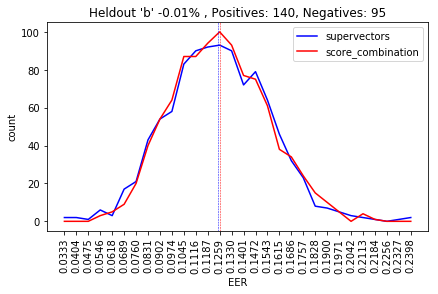

/Users/lmatayoshi/Documents/Projects/tesis_notebooks/final_experiments/heldout/plots/score_combination/g_lowercase


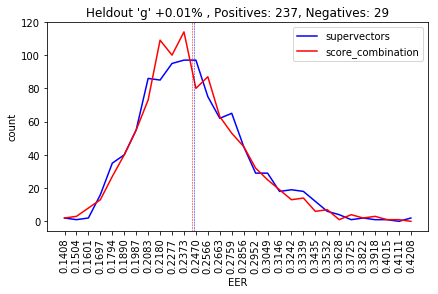

/Users/lmatayoshi/Documents/Projects/tesis_notebooks/final_experiments/heldout/plots/score_combination/z


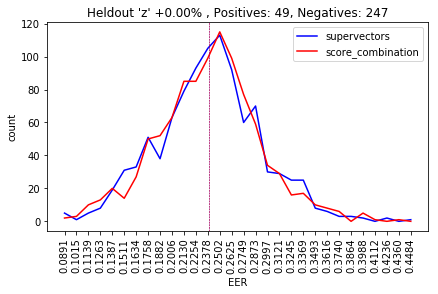

/Users/lmatayoshi/Documents/Projects/tesis_notebooks/final_experiments/heldout/plots/score_combination/w


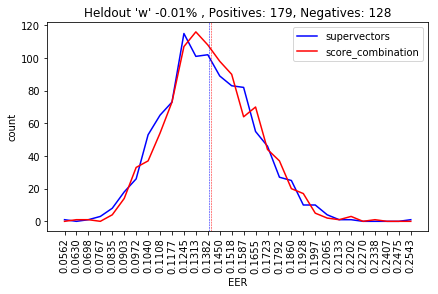

/Users/lmatayoshi/Documents/Projects/tesis_notebooks/final_experiments/heldout/plots/score_combination/N


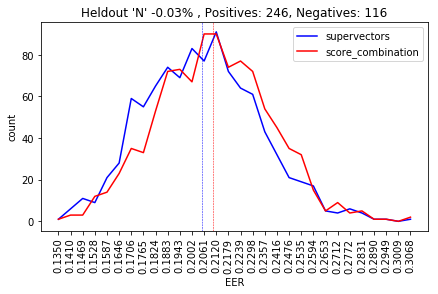

/Users/lmatayoshi/Documents/Projects/tesis_notebooks/final_experiments/heldout/plots/score_combination/B


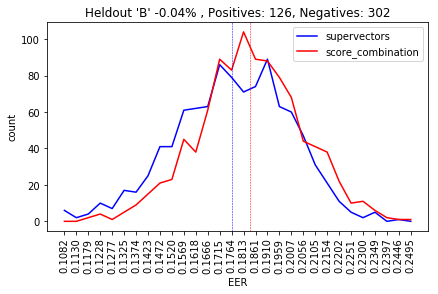

/Users/lmatayoshi/Documents/Projects/tesis_notebooks/final_experiments/heldout/plots/score_combination/rr


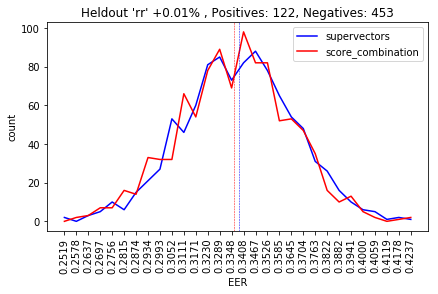

/Users/lmatayoshi/Documents/Projects/tesis_notebooks/final_experiments/heldout/plots/score_combination/u


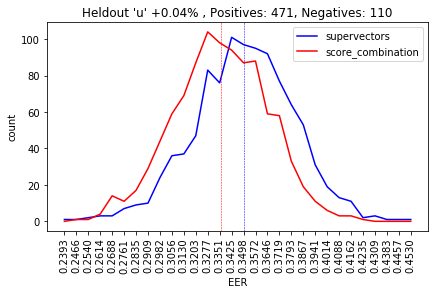

/Users/lmatayoshi/Documents/Projects/tesis_notebooks/final_experiments/heldout/plots/score_combination/p


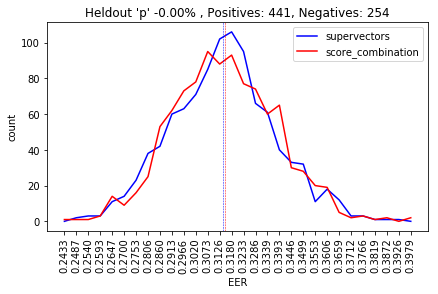

/Users/lmatayoshi/Documents/Projects/tesis_notebooks/final_experiments/heldout/plots/score_combination/D


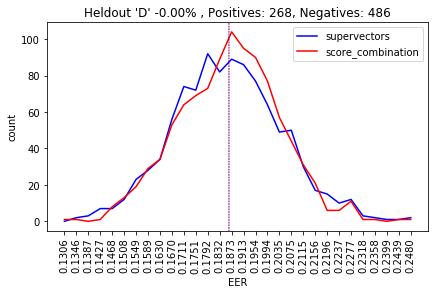

/Users/lmatayoshi/Documents/Projects/tesis_notebooks/final_experiments/heldout/plots/score_combination/y_lowercase


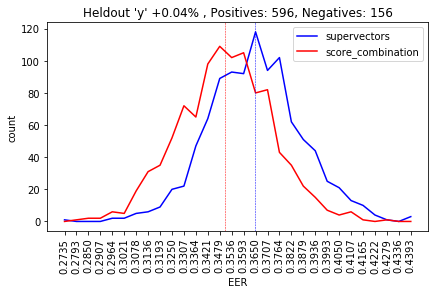

/Users/lmatayoshi/Documents/Projects/tesis_notebooks/final_experiments/heldout/plots/score_combination/k


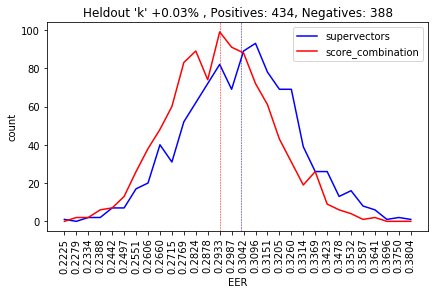

/Users/lmatayoshi/Documents/Projects/tesis_notebooks/final_experiments/heldout/plots/score_combination/m


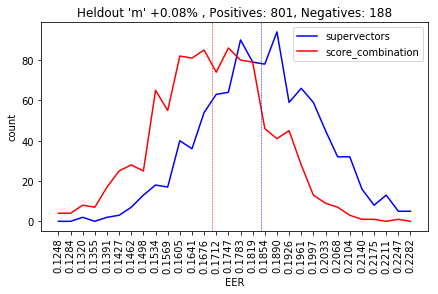

/Users/lmatayoshi/Documents/Projects/tesis_notebooks/final_experiments/heldout/plots/score_combination/t


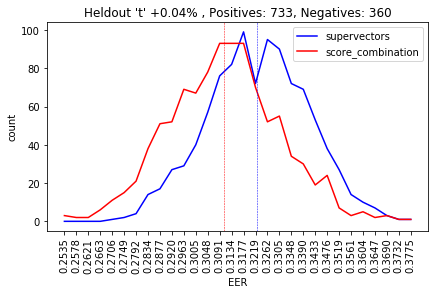

/Users/lmatayoshi/Documents/Projects/tesis_notebooks/final_experiments/heldout/plots/score_combination/l


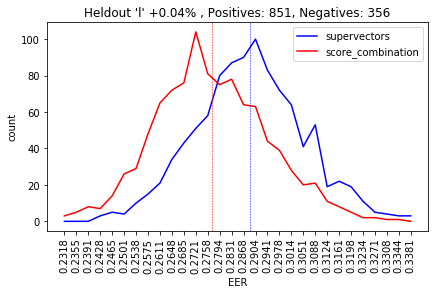

/Users/lmatayoshi/Documents/Projects/tesis_notebooks/final_experiments/heldout/plots/score_combination/i


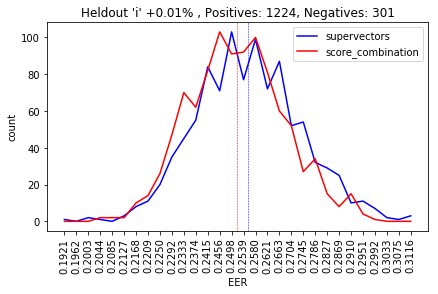

/Users/lmatayoshi/Documents/Projects/tesis_notebooks/final_experiments/heldout/plots/score_combination/r


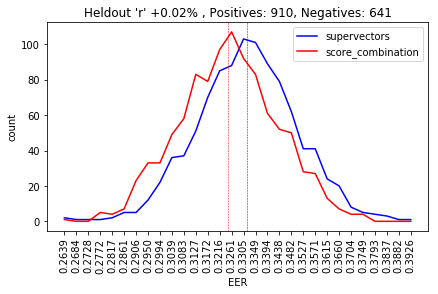

/Users/lmatayoshi/Documents/Projects/tesis_notebooks/final_experiments/heldout/plots/score_combination/n_lowercase


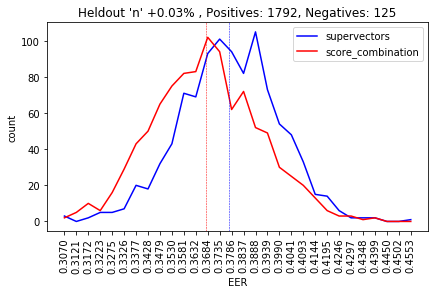

/Users/lmatayoshi/Documents/Projects/tesis_notebooks/final_experiments/heldout/plots/score_combination/s


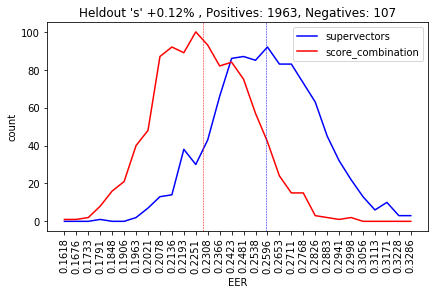

/Users/lmatayoshi/Documents/Projects/tesis_notebooks/final_experiments/heldout/plots/score_combination/o


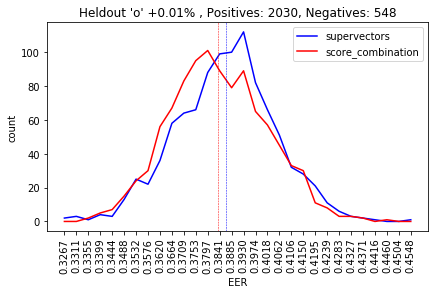

/Users/lmatayoshi/Documents/Projects/tesis_notebooks/final_experiments/heldout/plots/score_combination/a


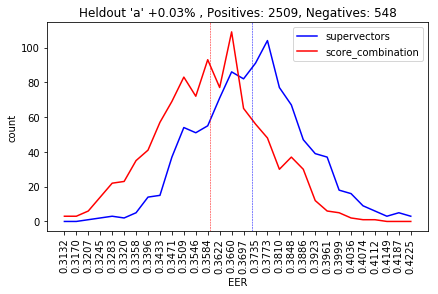

/Users/lmatayoshi/Documents/Projects/tesis_notebooks/final_experiments/heldout/plots/score_combination/e


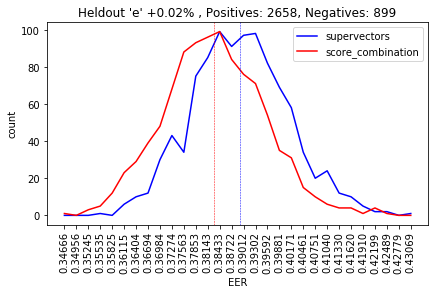

In [175]:
for p in phonemes:
    output_phoneme = p
    if p in ['g', 'y', 'd', 'b', 'n']:
        output_phoneme = p + "_lowercase"
    output_filename = score_combination_plots_dir + output_phoneme
    print output_filename
    title_info = {
        'n_positives': positives_dict[p], 
        'n_negatives': negatives_dict[p], 
        #'p-value': pvalues_score_combination_dict[p]
        'p-value': ""
    }
    plot_and_save_histogram(supervectors[p], score_combination[p], p, "score_combination", title_info, output_filename=output_filename)

# Features combination

/Users/lmatayoshi/Documents/Projects/tesis_notebooks/final_experiments/heldout/plots/features_combination/c


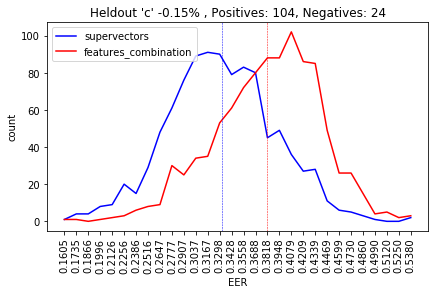

/Users/lmatayoshi/Documents/Projects/tesis_notebooks/final_experiments/heldout/plots/features_combination/x


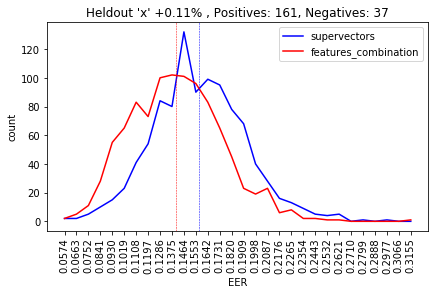

/Users/lmatayoshi/Documents/Projects/tesis_notebooks/final_experiments/heldout/plots/features_combination/G


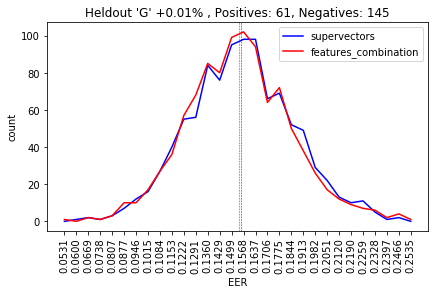

/Users/lmatayoshi/Documents/Projects/tesis_notebooks/final_experiments/heldout/plots/features_combination/d_lowercase


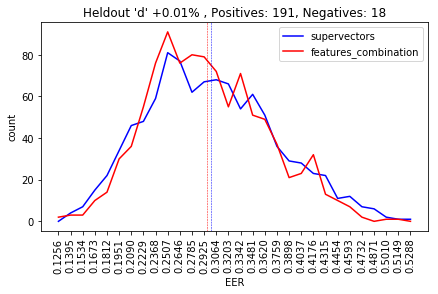

/Users/lmatayoshi/Documents/Projects/tesis_notebooks/final_experiments/heldout/plots/features_combination/b_lowercase


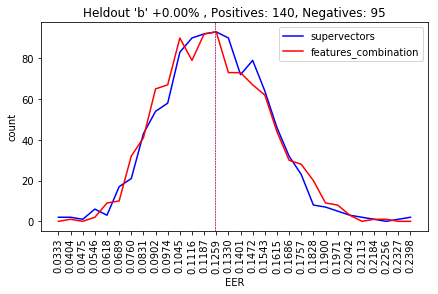

/Users/lmatayoshi/Documents/Projects/tesis_notebooks/final_experiments/heldout/plots/features_combination/g_lowercase


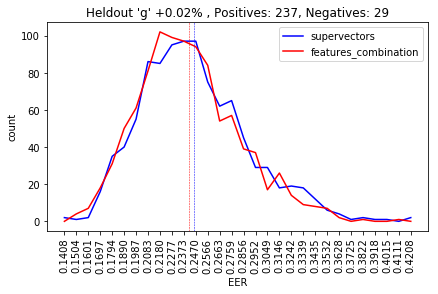

/Users/lmatayoshi/Documents/Projects/tesis_notebooks/final_experiments/heldout/plots/features_combination/z


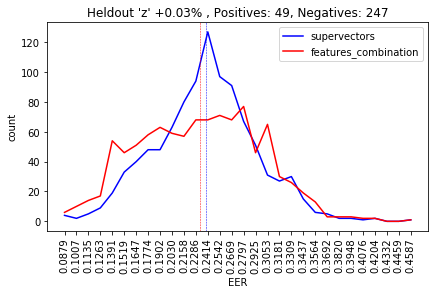

/Users/lmatayoshi/Documents/Projects/tesis_notebooks/final_experiments/heldout/plots/features_combination/w


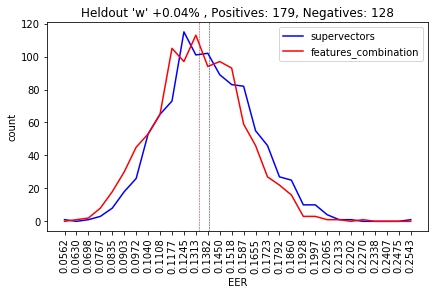

/Users/lmatayoshi/Documents/Projects/tesis_notebooks/final_experiments/heldout/plots/features_combination/N


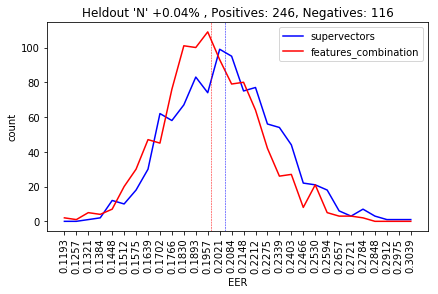

/Users/lmatayoshi/Documents/Projects/tesis_notebooks/final_experiments/heldout/plots/features_combination/B


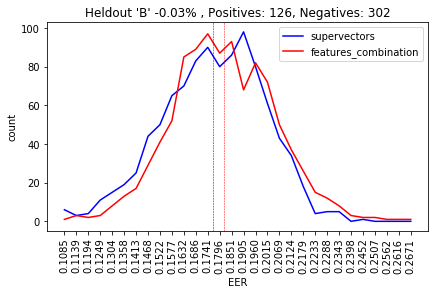

/Users/lmatayoshi/Documents/Projects/tesis_notebooks/final_experiments/heldout/plots/features_combination/rr


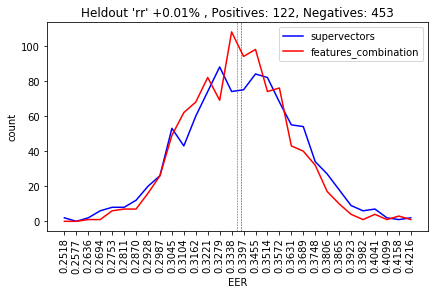

/Users/lmatayoshi/Documents/Projects/tesis_notebooks/final_experiments/heldout/plots/features_combination/u


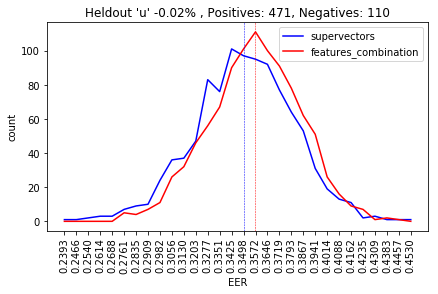

/Users/lmatayoshi/Documents/Projects/tesis_notebooks/final_experiments/heldout/plots/features_combination/p


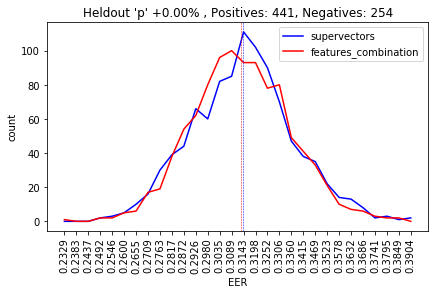

/Users/lmatayoshi/Documents/Projects/tesis_notebooks/final_experiments/heldout/plots/features_combination/D


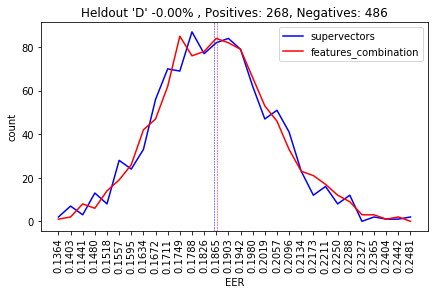

/Users/lmatayoshi/Documents/Projects/tesis_notebooks/final_experiments/heldout/plots/features_combination/y_lowercase


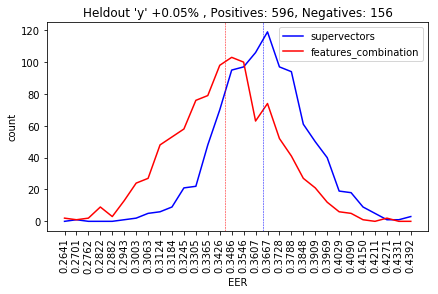

/Users/lmatayoshi/Documents/Projects/tesis_notebooks/final_experiments/heldout/plots/features_combination/k


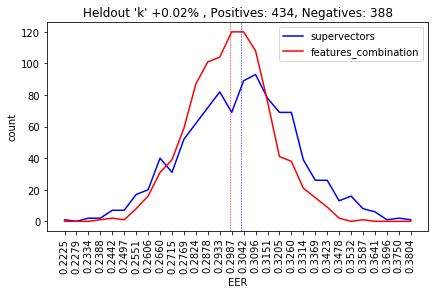

/Users/lmatayoshi/Documents/Projects/tesis_notebooks/final_experiments/heldout/plots/features_combination/m


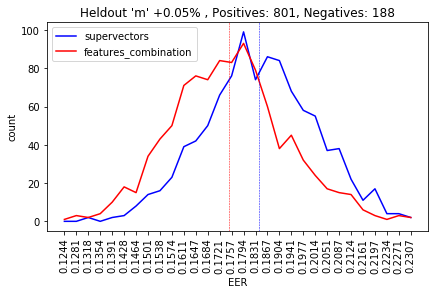

/Users/lmatayoshi/Documents/Projects/tesis_notebooks/final_experiments/heldout/plots/features_combination/t


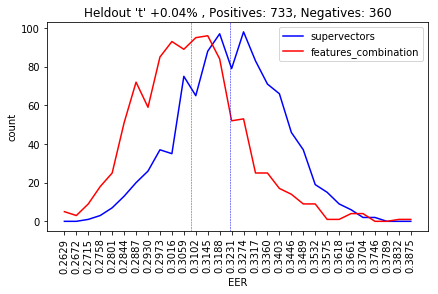

/Users/lmatayoshi/Documents/Projects/tesis_notebooks/final_experiments/heldout/plots/features_combination/l


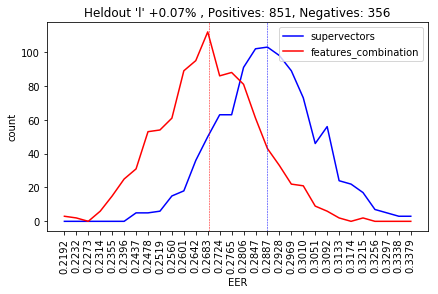

/Users/lmatayoshi/Documents/Projects/tesis_notebooks/final_experiments/heldout/plots/features_combination/i


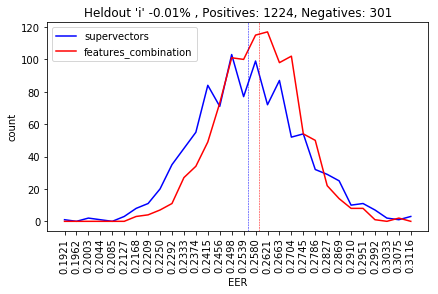

/Users/lmatayoshi/Documents/Projects/tesis_notebooks/final_experiments/heldout/plots/features_combination/r


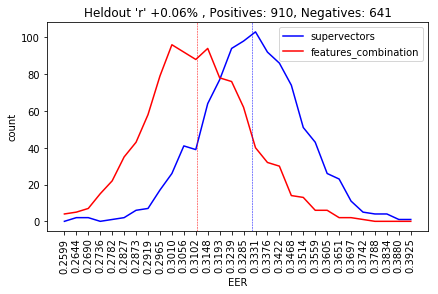

/Users/lmatayoshi/Documents/Projects/tesis_notebooks/final_experiments/heldout/plots/features_combination/n_lowercase


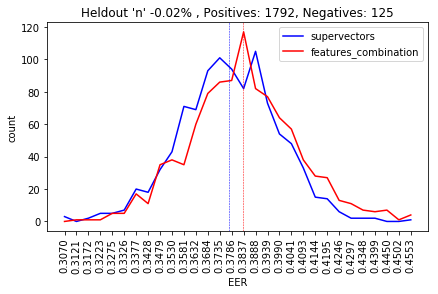

/Users/lmatayoshi/Documents/Projects/tesis_notebooks/final_experiments/heldout/plots/features_combination/s


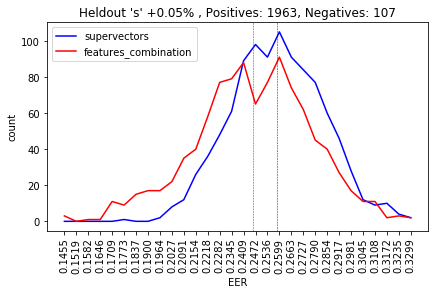

/Users/lmatayoshi/Documents/Projects/tesis_notebooks/final_experiments/heldout/plots/features_combination/o


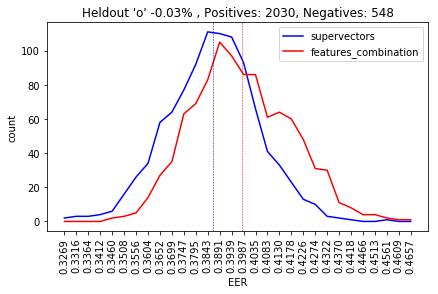

/Users/lmatayoshi/Documents/Projects/tesis_notebooks/final_experiments/heldout/plots/features_combination/a


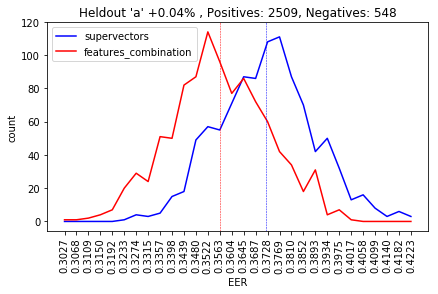

/Users/lmatayoshi/Documents/Projects/tesis_notebooks/final_experiments/heldout/plots/features_combination/e


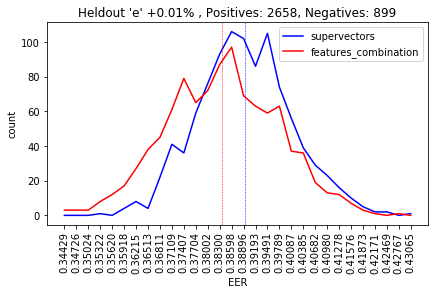

In [176]:
for p in phonemes:
    output_phoneme = p
    if p in ['g', 'y', 'd', 'b', 'n']:
        output_phoneme = p + "_lowercase"
    output_filename = features_combination_plots_dir + output_phoneme
    print output_filename
    title_info = {
        'n_positives': positives_dict[p], 
        'n_negatives': negatives_dict[p], 
        #'p-value': pvalues_features_combination_dict[p]
        'p-value': ""
    }
    plot_and_save_histogram(supervectors[p], features_combination[p], p, "features_combination", title_info, output_filename=output_filename)